In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### Load the dataset.

In [2]:
# https://www.tensorflow.org/datasets/splits
# Load first 100000 samples of training data and first 1000 of test data
train_ds, test_ds = tfds.load(name='genomics_ood', as_supervised=True, split=['train[0:100000]', 'test[0:1000]']);

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


### Build the TensorFlow dataset: Input pipeline

In [3]:
def onehotify(tensor):
    vocab = {'A':'0', 'C': '1', 'G':'2', 'T':'3'}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
    onehot = tf.one_hot(labels, 4) 
    onehot = tf.reshape(onehot, (-1,))
    return onehot

# Convert input string into onehot tensor using above function
# Conver input label into onehot tensor using tf.one_hot
def onehotify_data_input(input,label):
    return (onehotify(input), tf.one_hot(label, depth=10))

# Function to process datasets
# Converts inputs and labels into onehot representations
# Converts inputs into batches of specified size
# Assumes inputs and targets are already zipped together (in tuple form)
def process_ds(ds, batch_size=128):  

    # Map all data points to their corresponding onehot representations
    dataset = ds.map(onehotify_data_input)

    # Batch and shuffle
    dataset = dataset.batch(batch_size)
    dataset = dataset.shuffle(buffer_size=128)

    return dataset;

# Process loaded training dataset
train_dataset = process_ds(train_ds)

# Process loaded test dataset
test_dataset = process_ds(test_ds)



### Build the model.

In [4]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    def __init__(self):
        super(Model, self).__init__()

        # Define the three layers.
        self.hidden1 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.hidden2 = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.sigmoid)
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax)
    def call(self, inputs):      
        # Define the forward step.
        return self.output_layer(self.hidden2(self.hidden1(inputs)))

### Train the model.

In [5]:
#taken from the courseware-notebook

def train_step(model, input, target, loss_function, optimizer):

    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy
  



In [7]:
#taken from the courseware-notebook, the running average was removed

tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    train_loss=0
    for (inputs,target) in train_dataset:
        train_loss += train_step(model, inputs, target, cross_entropy_loss, optimizer)
    train_losses.append(train_loss/len(train_dataset))

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


### Visualize the training progress.

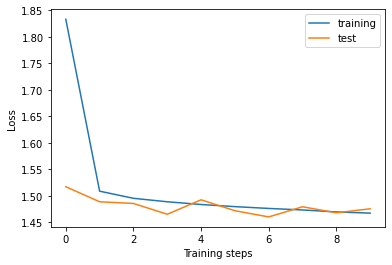

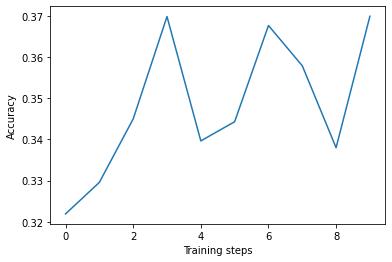

In [8]:
#taken from the courseware notebook

# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
x = list(range(num_epochs));
line1, = plt.plot(x, train_losses, label='training')
line2, = plt.plot(x, test_losses, label='test')
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
